In [11]:
import pandas as pd
import datetime
import numpy as np
from dateutil import parser
import pymysql
import matplotlib.pyplot as plt

def run_cx_sql_rio():
    try:
        
        conn = pymysql.connect(host='rp000100430', user='doc360_prd_app', passwd='PPWK43:8Ds9qUf', db='doc360_ingest_prd')
        cursor = conn.cursor()
        query = "select received_time, parent_batch, data_group from doc360_ingest_prd.master_recon where data_group in ('u_edi_claim','u_keyed_claim','u_clinical_docs')  and Received_time between  '2023-01-01' and '2023-07-02' and status like ('Complete%')"
        cursor.execute(query)
        rows = cursor.fetchall()
        count_parentid = len(rows)
        cursor.close()
        conn.close()

        if (len(rows) == 0):
            return "No record Found in RIO DB "

        else:
            arr = np.array(rows)
            df = pd.DataFrame(arr)
            df.columns =['Received_Date', 'Parent_Batch_Id', 'Datagroup_Name']
            #print(df)
            df['date'] = [d.date() for d in df['Received_Date']]
            df = df.drop('Received_Date', axis=1)
            df = df.drop_duplicates()
            return df
                       


    except Exception as e:
        return ("Error occured with database connection/querry result."), e

df=run_cx_sql_rio()
df

,Parent_Batch_Id,Datagroup_Name,date
0,121146781,u_clinical_docs,2023-01-22
1,121146782,u_clinical_docs,2023-01-22
2,121146783,u_clinical_docs,2023-01-22
3,121146784,u_clinical_docs,2023-01-22
4,121146787,u_clinical_docs,2023-01-22
...,...,...,...
9966911,147384717,u_clinical_docs,2023-07-01
9966912,147384720,u_clinical_docs,2023-07-01
9966913,147384721,u_clinical_docs,2023-07-01
9966914,147384722,u_clinical_docs,2023-07-01


In [42]:
df['count'] = 1
result = df.pivot_table(index=['date'], columns='Datagroup_Name', values='count',fill_value=0, aggfunc=np.sum)
result.columns = [f'{x}' for x in result.columns]
result = result.reset_index()
result
result=result.drop('u_clinical_docs',axis=1)
result

,date,u_edi_claim,u_keyed_claim
0,2023-01-22,7,2
1,2023-01-23,0,0
2,2023-01-24,7,2
3,2023-01-25,7,2
4,2023-01-26,7,2
...,...,...,...
156,2023-06-27,7,2
157,2023-06-28,7,2
158,2023-06-29,7,2
159,2023-06-30,9,2


In [63]:
result.to_excel('tedi_data.xlsx', index=False)
 


In [64]:
df = pd.read_excel('tedi_data.xlsx')
df

,date,u_edi_claim,u_keyed_claim
0,2023-01-22,7,2
1,2023-01-23,0,0
2,2023-01-24,7,2
3,2023-01-25,7,2
4,2023-01-26,7,2
...,...,...,...
156,2023-06-27,7,2
157,2023-06-28,7,2
158,2023-06-29,7,2
159,2023-06-30,9,2


In [65]:
len(df)

161

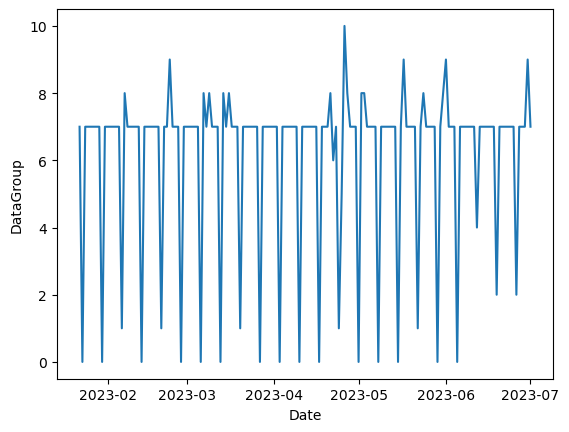

In [67]:
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline
plt.xlabel('Date')
plt.ylabel('DataGroup')
plt.plot(df.date,df['u_edi_claim'])

In [68]:
df['u_edi_claim'].values


array([ 7,  0,  7,  7,  7,  7,  7,  7,  0,  7,  7,  7,  7,  7,  7,  1,  8,
        7,  7,  7,  7,  7,  0,  7,  7,  7,  7,  7,  7,  1,  7,  7,  9,  7,
        7,  7,  0,  7,  7,  7,  7,  7,  7,  0,  8,  7,  8,  7,  7,  7,  0,
        8,  7,  8,  7,  7,  7,  1,  7,  7,  7,  7,  7,  7,  0,  7,  7,  7,
        7,  7,  7,  0,  7,  7,  7,  7,  7,  7,  0,  7,  7,  7,  7,  7,  7,
        0,  7,  7,  7,  8,  6,  7,  1,  5, 10,  8,  7,  7,  7,  0,  8,  8,
        7,  7,  7,  7,  0,  7,  7,  7,  7,  7,  7,  0,  7,  9,  7,  7,  7,
        7,  1,  7,  8,  7,  7,  7,  7,  0,  7,  8,  9,  7,  7,  7,  0,  7,
        7,  7,  7,  7,  7,  4,  7,  7,  7,  7,  7,  7,  2,  7,  7,  7,  7,
        7,  7,  2,  7,  7,  7,  9,  7], dtype=int64)

In [69]:
# univariate lstm example
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [70]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [71]:
# define input sequence
timeseries_data = df['u_edi_claim'].values
# choose a number of time steps
n_steps = 3
# split into samples
X, y = prepare_data(timeseries_data, n_steps)
print(X),print(y)

[[ 7  0  7]
 [ 0  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  0]
 [ 7  0  7]
 [ 0  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  1]
 [ 7  1  8]
 [ 1  8  7]
 [ 8  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  0]
 [ 7  0  7]
 [ 0  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  1]
 [ 7  1  7]
 [ 1  7  7]
 [ 7  7  9]
 [ 7  9  7]
 [ 9  7  7]
 [ 7  7  7]
 [ 7  7  0]
 [ 7  0  7]
 [ 0  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  0]
 [ 7  0  8]
 [ 0  8  7]
 [ 8  7  8]
 [ 7  8  7]
 [ 8  7  7]
 [ 7  7  7]
 [ 7  7  0]
 [ 7  0  8]
 [ 0  8  7]
 [ 8  7  8]
 [ 7  8  7]
 [ 8  7  7]
 [ 7  7  7]
 [ 7  7  1]
 [ 7  1  7]
 [ 1  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  0]
 [ 7  0  7]
 [ 0  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  0]
 [ 7  0  7]
 [ 0  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  0]
 [ 7  0  7]
 [ 0  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7  7  7]
 [ 7

(None, None)

In [72]:
X.shape

(158, 3)

In [73]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [74]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=300, verbose=1)

Epoch 1/300
5/5 [==============================] - 3s 11ms/step - loss: 42.6441
Epoch 2/300
5/5 [==============================] - 0s 12ms/step - loss: 40.0714
Epoch 3/300
5/5 [==============================] - 0s 9ms/step - loss: 36.5066
Epoch 4/300
5/5 [==============================] - 0s 9ms/step - loss: 31.5818
Epoch 5/300
5/5 [==============================] - 0s 11ms/step - loss: 24.2756
Epoch 6/300
5/5 [==============================] - 0s 9ms/step - loss: 15.2688
Epoch 7/300
5/5 [==============================] - 0s 10ms/step - loss: 14.3020
Epoch 8/300
5/5 [==============================] - 0s 10ms/step - loss: 13.2339
Epoch 9/300
5/5 [==============================] - 0s 10ms/step - loss: 11.7850
Epoch 10/300
5/5 [==============================] - 0s 10ms/step - loss: 11.9295
Epoch 11/300
5/5 [==============================] - 0s 9ms/step - loss: 11.3981
Epoch 12/300
5/5 [==============================] - 0s 9ms/step - loss: 10.9691
Epoch 13/300
5/5 [========================

Epoch 104/300
5/5 [==============================] - 0s 8ms/step - loss: 4.5151
Epoch 105/300
5/5 [==============================] - 0s 11ms/step - loss: 4.5217
Epoch 106/300
5/5 [==============================] - 0s 8ms/step - loss: 4.5293
Epoch 107/300
5/5 [==============================] - 0s 8ms/step - loss: 4.5127
Epoch 108/300
5/5 [==============================] - 0s 9ms/step - loss: 4.5437
Epoch 109/300
5/5 [==============================] - 0s 11ms/step - loss: 4.5129
Epoch 110/300
5/5 [==============================] - 0s 6ms/step - loss: 4.5246
Epoch 111/300
5/5 [==============================] - 0s 7ms/step - loss: 4.4839
Epoch 112/300
5/5 [==============================] - 0s 9ms/step - loss: 4.5333
Epoch 113/300
5/5 [==============================] - 0s 10ms/step - loss: 4.5242
Epoch 114/300
5/5 [==============================] - 0s 11ms/step - loss: 4.4884
Epoch 115/300
5/5 [==============================] - 0s 8ms/step - loss: 4.5308
Epoch 116/300
5/5 [=================

5/5 [==============================] - 0s 10ms/step - loss: 4.4253
Epoch 207/300
5/5 [==============================] - 0s 9ms/step - loss: 4.4548
Epoch 208/300
5/5 [==============================] - 0s 10ms/step - loss: 4.4219
Epoch 209/300
5/5 [==============================] - 0s 9ms/step - loss: 4.4300
Epoch 210/300
5/5 [==============================] - 0s 8ms/step - loss: 4.4115
Epoch 211/300
5/5 [==============================] - 0s 9ms/step - loss: 4.4505
Epoch 212/300
5/5 [==============================] - 0s 11ms/step - loss: 4.5113
Epoch 213/300
5/5 [==============================] - 0s 10ms/step - loss: 4.4494
Epoch 214/300
5/5 [==============================] - 0s 10ms/step - loss: 4.5086
Epoch 215/300
5/5 [==============================] - 0s 9ms/step - loss: 4.4045
Epoch 216/300
5/5 [==============================] - 0s 9ms/step - loss: 4.4683
Epoch 217/300
5/5 [==============================] - 0s 10ms/step - loss: 4.4253
Epoch 218/300
5/5 [=============================

In [86]:
# demonstrate prediction for next 10 days
x_input = np.array([7, 2, 7 ])
temp_input=list(x_input)
lst_output=[]
i=0
while(i<10):
    
    if(len(temp_input)>3):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
print(lst_output)


[7.461587]
1 day input [2.         7.         7.46158695]
1 day output [[7.3309097]]
2 day input [7.         7.46158695 7.33090973]
2 day output [[5.5263433]]
3 day input [7.461587  7.3309097 5.5263433]
3 day output [[6.51901]]
4 day input [7.3309097 5.5263433 6.51901  ]
4 day output [[4.945665]]
5 day input [5.5263433 6.51901   4.945665 ]
5 day output [[5.458945]]
6 day input [6.51901  4.945665 5.458945]
6 day output [[4.8121037]]
7 day input [4.945665  5.458945  4.8121037]
7 day output [[5.630755]]
8 day input [5.458945  4.8121037 5.630755 ]
8 day output [[4.9467072]]
9 day input [4.8121037 5.630755  4.9467072]
9 day output [[5.702782]]
[7.461587, 7.3309097, 5.5263433, 6.51901, 4.945665, 5.458945, 4.8121037, 5.630755, 4.9467072, 5.702782]
